# INTRODUCTION
## Title: Classifying Antibiotic Resistance in E. Coli from Gene Expressions Part I

- Antibiotic resistance arises through diverse molecular mechanisms, and expression based profiling offers a way to capture these global changes. In this project, I analyze gene expression data from E. Coli strains evolved under selection by ten different antibiotics. The overarching goal is to determine whether resistant strains group more distinctly by individual antibiotic treatment or by mechanism of action (MOA) category. By comparing clustering at these two levels, I want to assess whether expression signatures are primarily drug specific or if broader mechanistic patterns emerge. 

- To address this, this project is divided into two parts: 

Part I: Focuses on exploratory data analysis and preprocessing using unsupervised methods such as PCA and UMAP
Part II: Focuses on applying supervised machine learning to formally test whether drug or MOA level classification is more predictive

**Project Goals:** 
 **Exploratory Analysis & preprocessing **: 
- Visualize global gene expression patterns across E. coli strains evolved under 10 antibiotics.

- Use PCA to evaluate whether resistant strains cluster by drug or mechanism of action (MOA).

- Generate scree plots and linear PCA plots to assess variance explained.

- Apply non-linear dimensionality reduction (UMAP) on top principal components to test whether finer clustering emerges.

- Use silhouette scores and heatmaps of high-variance genes to quantify and visualize separability.

Why this matters:
Expression-based phenotyping could complement standard susceptibility testing by capturing global transcriptional changes associated with resistance, and may highlight shared versus drug-specific response signatures.


## DATASET
-**Accession**: GSE59408 (microarray)

-**Samples**: 40 resistant strains (4 per antibiotic x 10 drugs) + 2 parent controls

-**Design**: Parallel laboratory evolution under single drug selection and transcriptomes profiled post evolution.


## **Workflow:**
1.) Data Loading & Preparation:

- Loaded expression matrix and sample labels into Pandas DataFrames.

- Verified data integrity, removed parent strains, and checked for missing values.
- Added Labels
- Applied variance bases filtering to retain the most variable genes (unsupervised feature selection)

3.) Dimensionality Reduction & Visualization

- Standardized expression features and applied PCA to evaluate variance explained and visualize major axes of separation.

- Generated scree plots to determine number of components capturing most variance.

- Applied UMAP on top PCA components to visualize potential nonlinear structure.

- Compared separability by antibiotic identity vs MOA groups using scatterplots, heatmaps, and silhouette scores.

Antibiotic classes with their mechanisms of action for reference:

|CLASS                      | MECHANISM OF ACTION                                                                                   |EXAMPLES               |MOA GROUP|
|---------------------------|-------------------------------------------------------------------------------------------------------|-----------------------|---------|
|Cephalosporins             |Inhibit bacterial cell wall synthesis by binding to PBPs, preventing peptidoglycan cross linking.      |Cefoperazone, Cefixime |MOA1     |
|aminoglycosides            |Binds irreversibly to the 30S ribosomal subunit, causing mRNA misreading and blocking synthesis        |Amikacin, Neomycin     |MOA2     |
|Tetracyclines              |Binds to the 30S ribosomal subunit, blocking tRNA attachment and inhibiting protein synthesis          |Doxycycline            |MOA2     |
|Amphenicols                |Binds to the 50S ribosomal subunit, inhibiting peptidyl transferase activity, halting protein synthesis|Chloramphenicol        |MOA3     |
|Macrolides                 |Binds to the 50S ribosomal subunit, blocking translocation during protein synthesis                    |Azithromycin           |MOA3     |
|Folate synthesis inhibitors|Blocks folate synthesis pathway, trimethoprim -> inhibits dihydrofolate reductase                      |Trimethoprim           |MOA4     |
|Fluoroquinolones           |Inhibits DNA gyrase and topoisomerase IV, blocking DNA replication and transcription                   |Enoxacin, Ciprofloxacin|MOA5     |


In [155]:
# Importing packages

#core
import os 
import random 
import numpy as np 
import pandas as pd

#viz
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.metrics import silhouette_score

# Stats
from scipy.stats import ttest_ind

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [156]:
# 1.) Data Preparation: 

# Loading the dataset
deg_df = pd.read_csv(
    r"C:/Users/NathaliesPC/Desktop/Antibiotic_Project/GSE59408_top_table.tsv", sep="\t", comment="#")
deg_df.head()

#Importing expression matrix
expr_df = pd.read_csv(
    r"C:/Users/NathaliesPC/Desktop/Antibiotic_Project/GSE59408_series_matrix.txt",
    sep = "\t",
    skiprows = 63,
    nrows = 4469
)
# Setting gene ID as index
expr_df.set_index("ID_REF", inplace=True)

# Transposing the expression matrix 
expr_df = expr_df.T
expr_df.head()

# Coerce values to numeric in case there are any non-numeric values
expr_df = expr_df.apply(pd.to_numeric, errors = "coerce")

# Checking for missing values
expr_df = expr_df.dropna()
expr_df.shape

# log2 transformation if not already applied
if (expr_df.max().max() > 100):
    expr_df = np.log2(expr_df + 1)

# Reviewing the expression matrix
expr_df.head()

# Adding a variance filter
gene_variance = expr_df.var(axis=0)
top_genes = gene_variance.sort_values(ascending=False).head(2000).index
df_top_var = expr_df[top_genes]
df_top_var.shape

# Adding labels (Drug type) creating a dictionary to map sample IDs to labels, the labels are based on the antibiotic treatment (sample : resistance type):
sample_labels = {"GSM1436498" : "Parent 1",
                 "GSM1436499" : "Parent 2",

                 "GSM1436500" : "Cefoperazone",
                 "GSM1436501" : "Cefoperazone",
                 "GSM1436502" : "Cefoperazone",
                 "GSM1436503" : "Cefoperazone",

                 "GSM1436504" : "Cefixime",
                 "GSM1436505" : "Cefixime",
                 "GSM1436506" : "Cefixime",
                 "GSM1436507" : "Cefixime",

                 "GSM1436508" : "Amikacin",
                 "GSM1436509" : "Amikacin",
                 "GSM1436510" : "Amikacin",
                 "GSM1436511" : "Amikacin",

                 "GSM1436512" : "Neomycin",
                 "GSM1436513" : "Neomycin",
                 "GSM1436514" : "Neomycin",
                 "GSM1436515" : "Neomycin",

                 "GSM1436516" : "Doxycycline",
                 "GSM1436517" : "Doxycycline",
                 "GSM1436518" : "Doxycycline",
                 "GSM1436519" : "Doxycycline",

                 "GSM1436520" : "Chloramphenicol",
                 "GSM1436521" : "Chloramphenicol",
                 "GSM1436522" : "Chloramphenicol",
                 "GSM1436523" : "Chloramphenicol",

                 "GSM1436524" : "Azithromycin",
                 "GSM1436525" : "Azithromycin",
                 "GSM1436526" : "Azithromycin",
                 "GSM1436527" : "Azithromycin",

                 "GSM1436528" : "Trimethoprim",
                 "GSM1436529" : "Trimethoprim",
                 "GSM1436530" : "Trimethoprim",
                 "GSM1436531" : "Trimethoprim",

                 "GSM1436532" : "Enoxacin",
                 "GSM1436533" : "Enoxacin",
                 "GSM1436534" : "Enoxacin",
                 "GSM1436535" : "Enoxacin",
                 
                 "GSM1436536" : "Ciprofloxacin",
                 "GSM1436537" : "Ciprofloxacin",
                 "GSM1436538" : "Ciprofloxacin",
                 "GSM1436539" : "Ciprofloxacin",}


# Aligning expression matrix with labels
labels = [sample_labels[sid] for sid in df_top_var.index]
df_top_var["Label"] = labels
df_top_var.to_html("expression_matrix_with_labels.html")

# Removing 'Parent 1' and 'Parent 2' from the dataset for clarity
df_top_var = df_top_var[~df_top_var["Label"].str.contains("Parent")]
df_top_var.head()

# Adding labels for Mechanism of Action Groupings:
moa_labels = {
    "Parent 1" : "0",
    "Parent 2" : "0",
    "Cefoperazone" :"(MOA1)",
    "Cefixime" :"(MOA1)",
    "Amikacin" :"(MOA2)",
    "Neomycin" :"(MOA2)",
    "Doxycycline" :"(MOA2)",
    "Chloramphenicol" :"(MOA3)",
    "Azithromycin" :"(MOA3)",
    "Trimethoprim" :"(MOA4)",
    "Enoxacin" : "(MOA5)",
    "Ciprofloxacin" : "(MOA5)"
}

# Aligning expression matrix with MOA labels
groups = [moa_labels[drug] for drug in df_top_var["Label"]]
df_top_var["MOA_group"] = groups
df_top_var.head()

# reviewing expr_df
import webbrowser
df_top_var.to_html("expression_matrix_with_moa_labels.html")
webbrowser.open("expression_matrix_with_moa_labels.html", new=2)  # Open in a new tab to view

C:\Users\NathaliesPC\AppData\Local\Temp\ipykernel_32124\1373345512.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_var["Label"] = labels


True

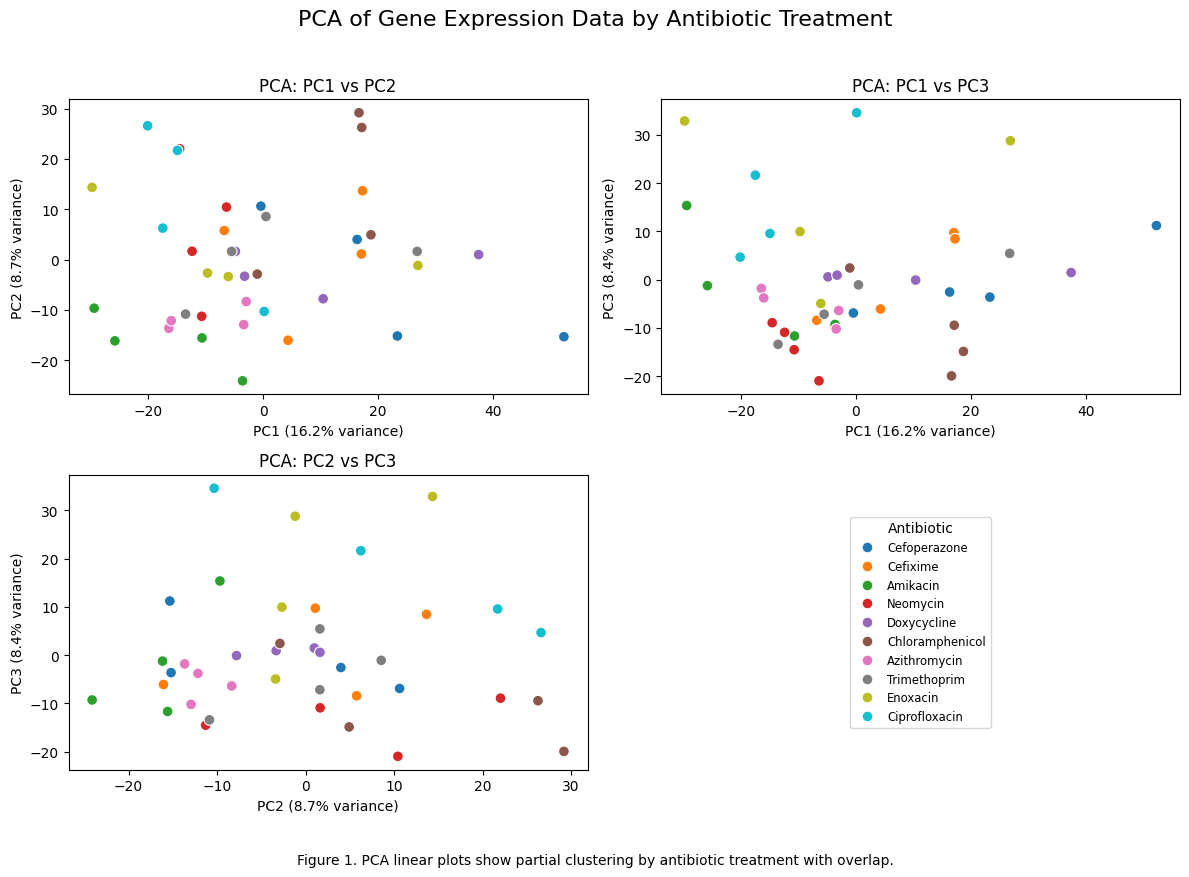

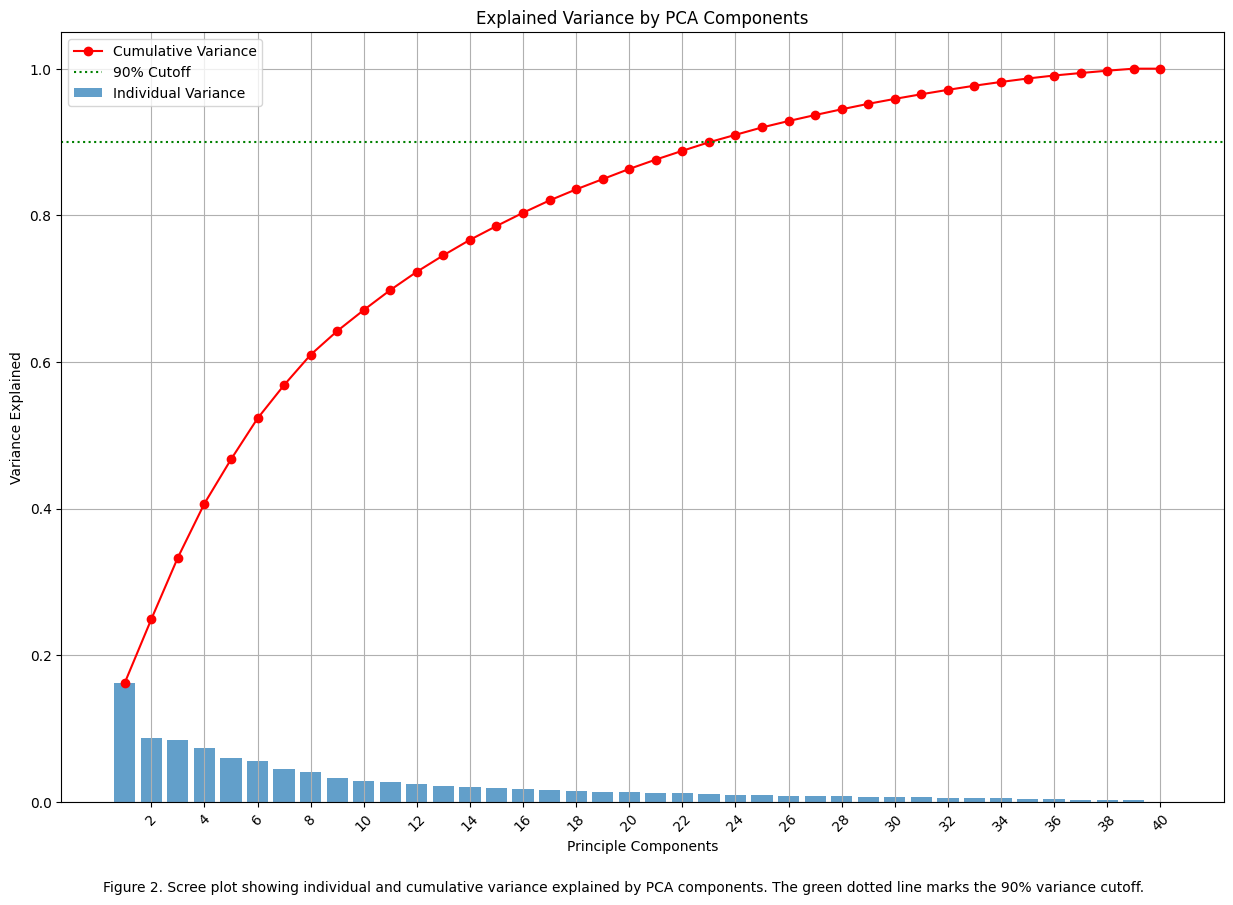

Cumulative explained variance for 24 components: 90.98%


In [157]:
# 3.) Dimensionality Reduction & Visualization, Based on Antibiotic Identity:

# Features only view
df_features = df_top_var.drop(columns=["Label", "MOA_group"], errors="ignore").select_dtypes(include=[np.number])

X = df_features.values
y_drug = df_top_var["Label"].values
y_moa  = df_top_var["MOA_group"].values

#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Performing PCA
pca = PCA(n_components=None, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)
var = pca.explained_variance_ratio_

# Creating a DataFrame for PCA results
pc_df = pd.DataFrame({ 
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'Label': y
}, index = df_top_var.index)

#PCA plots
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# PC1 vs PC2 (keep legend here so we can grab handles)
sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue="Label",
                s=60, linewidth=0.8, ax=axes[0, 0])
axes[0, 0].set_title("PCA: PC1 vs PC2")
axes[0, 0].set_xlabel(f"PC1 ({var[0]*100:.1f}% variance)")
axes[0, 0].set_ylabel(f"PC2 ({var[1]*100:.1f}% variance)")

# Grab legend handles/labels, then remove legend from this axis
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 0].get_legend().remove()

# PC1 vs PC3 (suppress legend)
sns.scatterplot(data=pc_df, x='PC1', y='PC3', hue="Label",
                s=60, linewidth=0.8, ax=axes[0, 1], legend=False)
axes[0, 1].set_title("PCA: PC1 vs PC3")
axes[0, 1].set_xlabel(f"PC1 ({var[0]*100:.1f}% variance)")
axes[0, 1].set_ylabel(f"PC3 ({var[2]*100:.1f}% variance)")

# PC2 vs PC3 (suppress legend)
sns.scatterplot(data=pc_df, x='PC2', y='PC3', hue="Label",
                s=60, linewidth=0.8, ax=axes[1, 0], legend=False)
axes[1, 0].set_title("PCA: PC2 vs PC3")
axes[1, 0].set_xlabel(f"PC2 ({var[1]*100:.1f}% variance)")
axes[1, 0].set_ylabel(f"PC3 ({var[2]*100:.1f}% variance)")

# Legend-only panel (bottom-right)
axes[1, 1].axis("off")
axes[1, 1].legend(handles, labels, title="Antibiotic", loc='center', fontsize='small')

# Main title & caption
fig.suptitle("PCA of Gene Expression Data by Antibiotic Treatment", y=0.97, fontsize=16)
fig.tight_layout(rect=[0, 0.06, 1, 0.95])
fig.text(0.5, 0.02,
         "Figure 1. PCA linear plots show partial clustering by antibiotic treatment with overlap.",
         ha='center', fontsize=10)

plt.show()

# SCREE plot to determine the number of components to retain
pca_all = PCA(n_components= None, random_state=SEED)
pca_all.fit(X_scaled)
var_ratio = pca_all.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

# Plotting the scree plot
plt.figure(figsize=(15, 10))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha = 0.7, label = 'Individual Variance')
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o', color='r', label = 'Cumulative Variance')
plt.axhline(y=0.90, color='g', linestyle=':', label='90% Cutoff')

plt.title("Explained Variance by PCA Components")
plt.xlabel("Principle Components")
plt.ylabel("Variance Explained")
plt.xticks(ticks = range(2, len(var_ratio) + 1,2),
           labels = range(2, len(var_ratio) + 1,2),
           rotation=45
           )
plt.legend()
plt.grid(True)
plt.figtext(0.5, 0.02,
         "Figure 2. Scree plot showing individual and cumulative variance explained by PCA components. The green dotted line marks the 90% variance cutoff.",
         ha='center', fontsize=10)
plt.show()

# Keeping N PCs for downstream 
num_pcs = 24
pca = PCA(n_components=num_pcs, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)
print(f"Cumulative explained variance for {num_pcs} components: {np.sum(pca.explained_variance_ratio_):.2%}")




## **PCA & SCREE PLOT SUMMARY**
- PCA linear plots show lots of overlap between antibiotic types. Nonlinear may better resolve groups (UMAP).
- The first 24 principle components explain 90.98% of the cumulative variance.

c:\Users\NathaliesPC\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


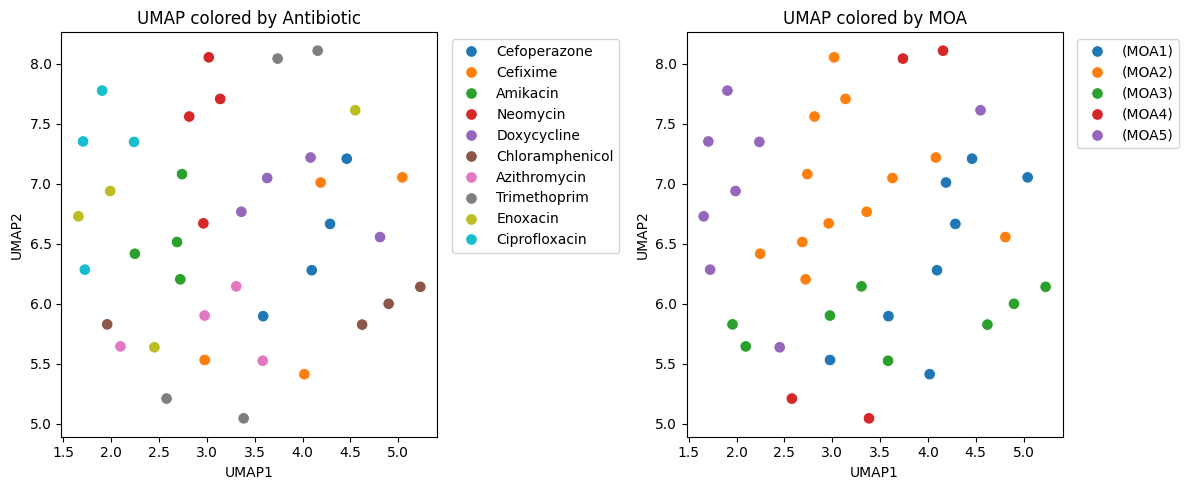

UMAP silhouette - Drug: -0.123271 | MOA : -0.002


In [158]:
#4.) UMAP on top PCs
umap_model = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    metric = "euclidean",
    random_state=SEED
)
X_umap = umap_model.fit_transform(X_pca)

# UMAP df
umap_df = pd.DataFrame({
    "UMAP1": X_umap[:,0],
    "UMAP2": X_umap[:,1],
    "Label": y_drug,
    "MOA": y_moa
}, index = df_top_var.index)

# UMAP plots
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.scatterplot(data=umap_df, x="UMAP1", y ="UMAP2", hue = "Label", s = 70, ax= axes[0])
axes[0].set_title("UMAP colored by Antibiotic")
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue='MOA', s = 70, ax=axes[1])
axes[1].set_title("UMAP colored by MOA")
axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Silhouette scores
sil_drug_umap = silhouette_score(X_umap, y_drug)
sil_moa_umap = silhouette_score(X_umap, y_moa)
print(f"UMAP silhouette - Drug: {sil_drug_umap:3f} | MOA : {sil_moa_umap:.3f}")

## **UMAP SUMMARY**
- Silhouette scores were consistently negative at the drug level (~-0.1) and closer to zero at the MOA level (~0.0), confirming that unsupervised methods reveal little about natural separation, with only weak structure at the mechanism level.

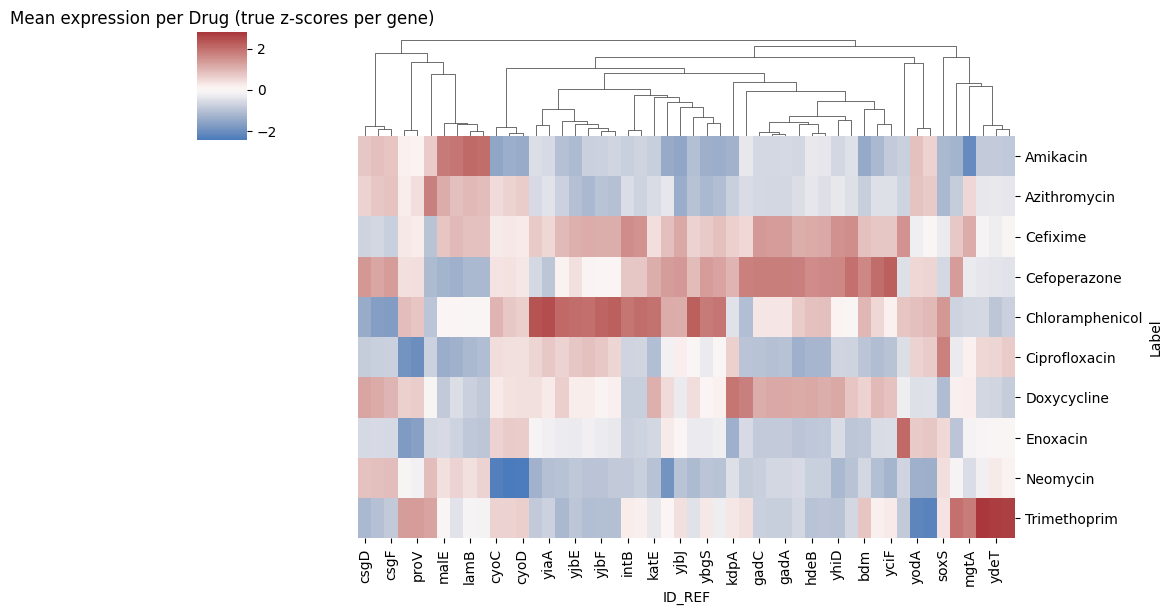

In [159]:
# Heatmap per drug type
# 1) numeric gene matrix
gene_cols = df_top_var.columns.difference(["Label","MOA_group"])
genes_df  = df_top_var[gene_cols]

# 2) average replicates per Drug
drug_means = genes_df.groupby(df_top_var["Label"]).mean()

# 3) choose the most variable genes *across drugs* (keeps figure readable)
topN = 50
top_genes = drug_means.var(axis=0).nlargest(topN).index
dm_top = drug_means[top_genes]

# 4) true z-scores per gene (column-wise)
scaler = StandardScaler(with_mean=True, with_std=True)
dm_z = pd.DataFrame(
    scaler.fit_transform(dm_top),  # rows=drugs, cols=genes
    index=dm_top.index, columns=dm_top.columns
)

# 5) plot (cluster genes only so drug order stays visible)
sns.clustermap(
    dm_z, cmap="vlag", center=0,
    row_cluster=False, col_cluster=True,
    figsize=(10,6)
)
plt.title("Mean expression per Drug (true z-scores per gene)")
plt.show()


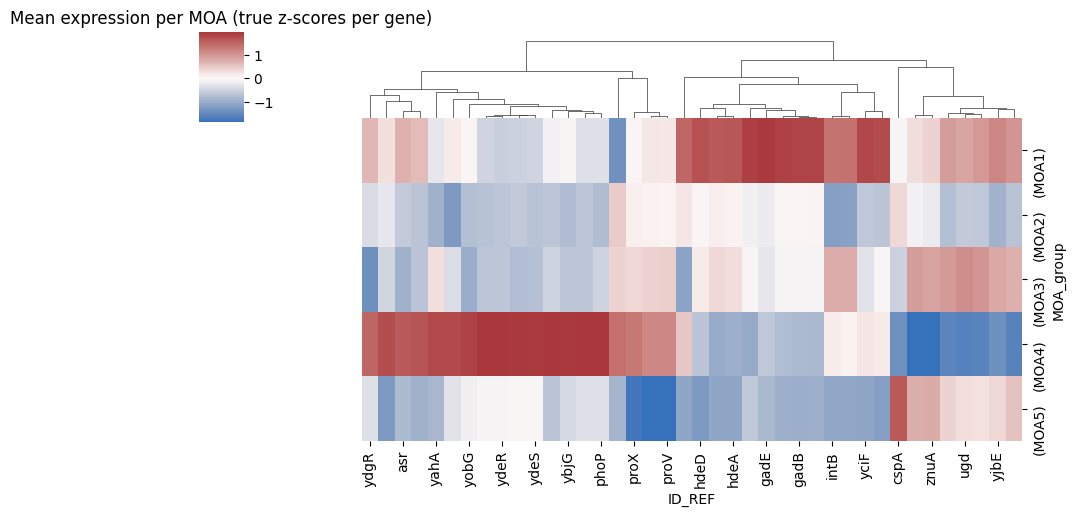

In [160]:
# Heatmap per MOA
# 1) average replicates per MOA
moa_means = genes_df.groupby(df_top_var["MOA_group"]).mean()

# 2) pick genes that vary most *between MOAs*
topN = 40
top_genes = moa_means.var(axis=0).nlargest(topN).index
mm_top = moa_means[top_genes]

# 3) true z-scores per gene
scaler = StandardScaler(with_mean=True, with_std=True)
mm_z = pd.DataFrame(
    scaler.fit_transform(mm_top),
    index=mm_top.index, columns=mm_top.columns
)

# 4) plot (cluster genes only; MOA rows stay ordered 0..5)
sns.clustermap(
    mm_z, cmap="vlag", center=0,
    row_cluster=False, col_cluster=True,
    figsize=(9,5)
)
plt.title("Mean expression per MOA (true z-scores per gene)")
plt.show()

## **HEATMAPS SUMMARY**
Heatmaps of top variance genes reinforce PCA/UMAP results. While certain antibiotics share consistent transcriptional signatures, overall clustering by individual drug is weak. In contrast, averaging expression profiles by MOA reveals stronger, more coherent patterns, particularly for cephalosporins and fluoroquinolones.

# **CONCLUSION**

In this part of the project, I used unsupervised methods to look at how gene expression patterns from resistant E. coli strains relate to the antibiotics they were evolved under. PCA and UMAP plots colored by antibiotic type showed a lot of overlap, and the silhouette score for drug-level clustering was consistently negative, which means the groups are not well separated.

When I recolored the plots by mechanism of action (MOA), the results looked a little better. Cephalosporins (MOA 1) and fluoroquinolones (MOA 5) tended to cluster together, while other groups like protein synthesis inhibitors (MOA 2) showed only partial grouping. The MOA level silhouette score (–0.002) was still negative, but it was closer to zero than the drug-level score, which suggests that MOA explains more of the structure in the data. The heatmaps supported this too. Averaging expression by drug was messy, but averaging by MOA gave cleaner patterns, especially for cephalosporins and fluoroquinolones.


Overall, the exploratory analysis suggests that MOA-level patterns are stronger than individual drug patterns, but that unsupervised methods alone are not enough to clearly separate the groups. Because of this, the next step (Part II) will be to use supervised machine learning with PCA features to test if drug type or MOA can be predicted more accurately from gene expression.

# REFERENCES
GEO Accession: [GSE59408](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE59408)  
- McInnes, L., Healy, J., & Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. *arXiv:1802.03426*.  
- Pedregosa, F. et al. (2011). Scikit-learn: Machine Learning in Python. *JMLR, 12*, 2825–2830.  